In [1]:
import numexpr as ne
import numpy as np
import tomocam
import tomopy
import dxchange as dx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import h5py
import os

In [2]:
def dXAtts(datafile, beamline='als'):
    attrs = dict()
    if beamline == 'als':
        fp = h5py.File(datafile, 'r')
        gdata = dict(dx.reader._find_dataset_group(fp).attrs)
        attrs['pxsize']           = float(gdata['pxsize']) / 10  # /10 to convert units from mm to cm
        attrs['nslices']          = int(gdata['nslices'])
        attrs['nangles']          = int(gdata['nangles'])
        attrs['arange']           = float(gdata['arange'])
        attrs['nrays']            = int(gdata['nrays'])
        attrs['i0cycle']          = int(gdata['i0cycle'])
        attrs['num_dark_fields']  = int(gdata['num_dark_fields'])
        attrs['ind_dark']         = list(range(0, attrs['num_dark_fields']))
        attrs['num_bright_filed'] = int(gdata['num_bright_field'])
        attrs['rot_angle']        = float(gdata['rot_angle'])
    return attrs

# Input

In [17]:
filename = '20200624_160459_llzo_stack_no14.h5'
inputPath = '/global/u2/d/dkumar/als/tomocam/data'
cor = 1279.375
inputFile = os.path.join(inputPath, filename)
gdata = dXAtts(inputFile)

# Output 

In [18]:
outputPath = '/global/u2/d/dkumar/als/tomocam/recon'
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
outputFile = os.path.join(outputPath, filename)

# Load data

In [21]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sinoUsed = (gdata['nslices']//2, gdata['nslices']//2 + 8, 1)
print(sinoUsed)
proj, flat, dark, ind = dx.read_als_832h5(inputFile, sino=sinoUsed)
proj = proj.astype(np.float32)

(354, 362, 1)


# Projection angles

In [22]:
offset = 0
angle_offset = 270 + offset
gdata = dXAtts(inputFile)
theta = tomopy.angles(gdata['nangles'], angle_offset, angle_offset - gdata['arange']).astype(np.float32)
print(theta)

[4.712389  4.7099943 4.7076    ... 1.5755854 1.5731908 1.5707964]


## Normalize and minus-log

In [23]:
proj = tomopy.normalize(proj, flat, dark, out=proj)
minimum_transmission = 0.01
mx = np.float32(minimum_transmission)
ne.evaluate('where(proj>mx, proj, mx)', out=proj)
proj = tomopy.minus_log(proj)

# Remove stripes

In [24]:
proj = tomopy.prep.stripe.remove_stripe_fw(proj, level = 7, sigma = 3)

In [25]:
sino = np.transpose(proj, [1, 0, 2]).astype(np.float32)

# Reconstruct object using MBIR

In [ ]:
s = 0.085   
max_iters = 1000
recon = tomocam.MBIR(sino, theta, center = cor, num_iters = max_iters, smoothness = s)

Iteration:   0 , Error:  1266.4805908203125
Iteration:   1 , Error:  974.9500732421875
Iteration:   2 , Error:  973.0823364257812
Iteration:   3 , Error:  970.6824951171875
Iteration:   4 , Error:  967.7884521484375
Iteration:   5 , Error:  964.4487915039062
Iteration:   6 , Error:  960.9598999023438
Iteration:   7 , Error:  957.3955078125
Iteration:   8 , Error:  953.5689086914062
Iteration:   9 , Error:  949.2366943359375
Iteration:   10 , Error:  944.5144653320312
Iteration:   11 , Error:  939.2098388671875
Iteration:   12 , Error:  933.3673095703125
Iteration:   13 , Error:  926.6485595703125
Iteration:   14 , Error:  919.06591796875
Iteration:   15 , Error:  910.2281494140625
Iteration:   16 , Error:  901.0061645507812
Iteration:   17 , Error:  890.9125366210938
Iteration:   18 , Error:  880.8720703125
Iteration:   19 , Error:  872.1676025390625
Iteration:   20 , Error:  862.9993286132812
Iteration:   21 , Error:  854.4299926757812
Iteration:   22 , Error:  845.5486450195312
Itera

# Mask each reconstructed slice with a circle.

In [15]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

# Show results

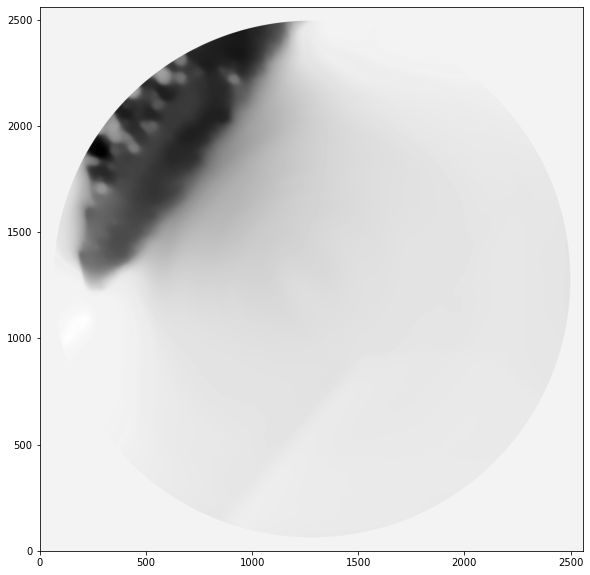

In [16]:
plt.imshow(recon[0], origin='lower', cmap='gray')

# Save to hdf5

In [ ]:
with h5py.File(outputFile, 'w') as fp:
    dset = fp.create_dataset('recon', data = recon)
    dset.attrs['smoothness'] = s
    dset.attrs['num_iters'] = max_iters
    dset.attrs['remove_stripe_fw'] = 'level : 7, sigma: 3'
    dset.attrs['minimum_transmission'] = minimum_transmission